# NFL Draft Success Analysis

In this notebook we analyze NFL data regarding team draft performance and team success in the following years. Three data sets are used for this project:

1. NFL Team Draft Data (who each team drafted which year)
2. NFL Player Performance Data (how each player performed each year in the NFL)
3. NFL Team Performance Data (how each team performed each year)

## Import

In [1]:
#Import Packages
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import datetime as dt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.cluster import Birch
from sklearn.cluster import KMeans

In [2]:
#Import files
ddf = pd.read_excel('team_draft_data.xlsx')
pdf = pd.read_excel('player_data.xlsx', sheet_name='final')
tpf = pd.read_excel('team_historical_records.xlsx', sheet_name = 'Cleaned')

## Analysis Description

In order to perform analysis on the data set, for each NFL draft class we need to sum the approximate value (AV) for each player over the first five years of their career. Then we do a sum for all the players for a single team as long as they were with that team. Therefore, players who were traded within that time frame will not add AV to the team after they have been traded. This will produce a cumulative 5 year team AV score for each team for each draft year.

The team AV score will then be compared to the team records for those years to observe trends in team draft performance and team performance. 

### Clean the dataframes: Player Yearly AV Data

In [3]:
#Remove the career totals
pdf = pdf[pdf.year != 'Career']
pdf

,year,age,team,av,name
0,2012,23,ARI,-5.0,Ryan Lindley
2,2 yrs,2 yrs,ARI,-4.0,Ryan Lindley
3,2009,26,CLE,-4.0,Derek Anderson
4,1998,26,PHI,-3.0,Bobby Hoying
6,2012,24,ARI,-2.0,John Skelton
...,...,...,...,...,...
50056,NaN,NaN,MIA,NaN,Austin Reiter
50057,NaN,NaN,NOR,NaN,Austin Reiter
50058,1 yr,1 yr,MIA,NaN,Austin Reiter
50059,1 yr,1 yr,NOR,NaN,Austin Reiter


In [4]:
#Remove total values for a team (values containing 'yr' or 'yrs') and just leave the year values 
pdf = pdf[(~pdf.year.str.contains('yrs', na=False)) & (~pdf.year.str.contains('yr', na=False))]
pdf

,year,age,team,av,name
0,2012,23,ARI,-5.0,Ryan Lindley
3,2009,26,CLE,-4.0,Derek Anderson
4,1998,26,PHI,-3.0,Bobby Hoying
6,2012,24,ARI,-2.0,John Skelton
7,2009,28,STL,-2.0,Kyle Boller
...,...,...,...,...,...
50054,2021,30,WAS,NaN,Brandon Scherff
50055,2021,30,2TM,NaN,Austin Reiter
50056,NaN,NaN,MIA,NaN,Austin Reiter
50057,NaN,NaN,NOR,NaN,Austin Reiter


In [5]:
#Check for null years
pdf.year.isnull().sum()

1551

In [6]:
#Remove null years
pdf = pdf[pdf.year.notna()]
pdf.year.isnull().sum()

0

In [7]:
#Remove any wierd characters in the year column (* and +)
pdf = pdf.replace(to_replace=r'\*', value='', regex=True)
pdf = pdf.replace(to_replace=r'\+' , value='', regex=True)

In [8]:
#Remove rows where the team says "2TM", "3TM", or "4TM" because it is not attributed to one team alone
pdf = pdf[(pdf.team != '2TM') & (pdf.team != '3TM') & (pdf.team != '4TM')]

In [9]:
#Remove rows where year is 2021 because the season is not finished
pdf = pdf[pdf.year != 2021]

In [10]:
#Convert year, age, and av to numeric values
for column in pdf.columns:
    if column == 'year' or column == 'age' or column == 'av':
        pdf[column] = pd.to_numeric(pdf[column])

In [11]:
#Replace team abbreviations with consistent team names
#load team abbreviations key
team_abvs = pd.read_excel('player_data.xlsx', sheet_name='team_abs')

#Place team abbreviation keys into a dictionary
team_keys = dict(team_abvs.values)

#change each team abbreviation to the team name
pdf = pdf.replace(team_keys)

In [12]:
pdf

,year,age,team,av,name
0,2012.0,23.0,Arizona Cardinals,-5.0,Ryan Lindley
3,2009.0,26.0,Cleveland Browns,-4.0,Derek Anderson
4,1998.0,26.0,Philadelphia Eagles,-3.0,Bobby Hoying
6,2012.0,24.0,Arizona Cardinals,-2.0,John Skelton
7,2009.0,28.0,Los Angeles Rams,-2.0,Kyle Boller
...,...,...,...,...,...
50050,2021.0,22.0,Washington Football Team,NaN,Saahdiq Charles
50051,2021.0,23.0,Washington Football Team,NaN,Keith Ismael
50052,2021.0,25.0,New York Giants,NaN,Wes Martin
50054,2021.0,30.0,Washington Football Team,NaN,Brandon Scherff


### Clean the dataframes: Team Historical Data

In [13]:
tpf

,year,Lg,team,W,L,T,Div. Finish,Playoffs,PF,PA,...,Yds.1,T/G,Pts±,Yds±,out of,MoV,SoS,SRS,OSRS,DSRS
0,2021,NFL,Arizona Cardinals,7,1,0,1st of 4,NaN,246,138,...,4,7,2,5,32,13.5,-0.3,13.2,6.3,7.0
1,2020,NFL,Arizona Cardinals,8,8,0,3rd of 4,NaN,410,367,...,13,17,13,11,32,2.7,-0.1,2.6,1.5,1.0
2,2019,NFL,Arizona Cardinals,5,10,1,4th of 4,NaN,361,442,...,32,18,23,29,32,-5.1,1.8,-3.2,-0.3,-2.9
3,2018,NFL,Arizona Cardinals,3,13,0,4th of 4,NaN,225,425,...,20,29,32,32,32,-12.5,1.0,-11.5,-9.6,-1.9
4,2017,NFL,Arizona Cardinals,8,8,0,3rd of 4,NaN,295,361,...,6,23,24,15,32,-4.1,0.4,-3.7,-4.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,1945,NFL,Washington Redskins*,8,2,0,1st of 5,Lost Champ,209,121,...,2,3,3,1,10,8.8,-4.8,4.0,0.3,3.8
2118,1943,NFL,Washington Redskins*,6,3,1,1st of 5,Lost Champ,229,137,...,3,3,2,4,10,9.2,-2.6,6.6,2.2,4.4
2119,1942,NFL,Washington Redskins*,10,1,0,1st of 5,Won Champ,227,102,...,2,7,2,2,10,11.4,-3.8,7.6,4.9,2.7
2120,1940,NFL,Washington Redskins*,9,2,0,1st of 5,Lost Champ,245,142,...,9,8,1,3,10,9.4,-2.9,6.5,7.3,-0.8


In [14]:
#Only taking into consideration the years from 1994 to 2020, and relevant columns. 
tpf = tpf[(tpf['year'] >= 1994) & (tpf['year'] <= 2020)]
tpf = tpf[['year','Lg','team','W','L','T','Div. Finish','Playoffs']]

In [15]:
# Removing the asterisk symbol in the Team's name and convert previous Team names to current ones.
tpf = tpf.replace(to_replace='\*', value='', regex=True)
tpf = tpf.replace(to_replace='Washington Redskins', value='Washington Football Team')
tpf = tpf.replace(to_replace='Oakland Raiders', value='Las Vegas Raiders')
tpf = tpf.replace(to_replace='San Diego Chargers', value='Los Angeles Chargers')
tpf = tpf.replace(to_replace='St. Louis Rams', value='Los Angeles Rams')
tpf = tpf.replace(to_replace='Houston Oilers', value='Tennessee Titans')

In [16]:
# Assigning numeric value to playoff stance. 
tpf['Playoffs'].replace({'Won SB':5,'Lost SB':4,'Lost Conf':3,'Lost Div':2,'Lost WC':1}, inplace=True)
tpf['Playoffs'] = tpf['Playoffs'].fillna(0)

### Clean the dataframes: Team Draft Data

In [17]:
#Only select the desired columns
ddf = ddf[['draft_year','round','name','pick','team']]

In [18]:
#Replace old team names with new team names
ddf['team'].replace({'Chicago/St. Louis/Arizona Cardinals':'Arizona Cardinals','Baltimore/Indianapolis Colts':'Indianapolis Colts'
                    ,'Cleveland/LA/St. Louis Rams':'Los Angeles Rams','Houston Oilers/Tennessee Titans':'Tennessee Titans',
                    'Las Vegas/LA/Oakland Raiders':'Las Vegas Raiders','San Diego/Los Angeles Chargers':'Los Angeles Chargers'}
                   , inplace=True)

## Player Data Analytics

<AxesSubplot:>

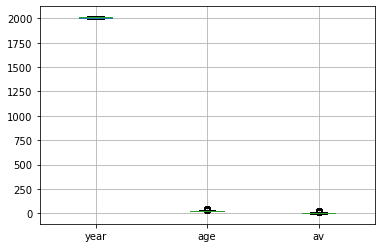

In [19]:
pdf.boxplot()

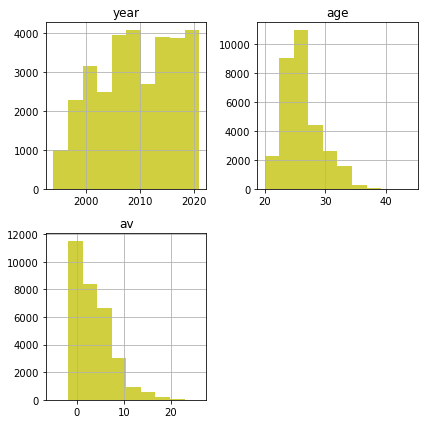

In [20]:
#Histogram of numerical values
pdf.hist(figsize=(6, 6), bins=10, alpha = 0.75, color = 'y')
plt.tight_layout()
plt.show()

In [21]:
pdf.describe()

,year,age,av
count,31556.000000,31477.000000,31376.000000
mean,2009.406515,26.147600,3.813074
std,7.216566,3.101485,3.737058
min,1994.000000,20.000000,-5.000000
25%,2004.000000,24.000000,1.000000
50%,2010.000000,26.000000,3.000000
75%,2016.000000,28.000000,6.000000
max,2021.000000,44.000000,26.000000


In [22]:
team_group = pdf.groupby(by=['team','year'], as_index = False)['av'].sum()
team_group

,team,year,av
0,Arizona Cardinals,1994.0,7.0
1,Arizona Cardinals,1995.0,22.0
2,Arizona Cardinals,1996.0,46.0
3,Arizona Cardinals,1997.0,59.0
4,Arizona Cardinals,1998.0,94.0
...,...,...,...
943,Washington Football Team,2017.0,168.0
944,Washington Football Team,2018.0,160.0
945,Washington Football Team,2019.0,133.0
946,Washington Football Team,2020.0,169.0


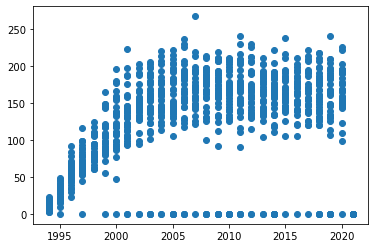

In [23]:
plt.scatter(team_group.year, team_group.av)

As we can see in the above chart, there is a curve that shows the AVs increasing until about the year 2000. Then there is a more standard distribution each year. This is because there are less players accounted for in the first 6 years of our collection, therefore the team AV is only accounting for a portion of the players that are actually on the team. As time goes on, a stronger percentage of people playing are people who went through the NFL draft. 

With that said, in order to get a base for understanding draft year AV in connection with performance, we need to understand the connection between a team's yearly AV and their performance. 

Let's do that below! And for the reasons in the findings about the above graph, we will exclude years before 2000.

In [24]:
team_av_wls = team_group.join(tpf.set_index(['team','year']), on=['team','year'])
team_av_wls

,team,year,av,Lg,W,L,T,Div. Finish,Playoffs
0,Arizona Cardinals,1994.0,7.0,NFL,8.0,8.0,0.0,3rd of 5,0.0
1,Arizona Cardinals,1995.0,22.0,NFL,4.0,12.0,0.0,5th of 5,0.0
2,Arizona Cardinals,1996.0,46.0,NFL,7.0,9.0,0.0,4th of 5,0.0
3,Arizona Cardinals,1997.0,59.0,NFL,4.0,12.0,0.0,5th of 5,0.0
4,Arizona Cardinals,1998.0,94.0,NFL,9.0,7.0,0.0,2nd of 5,2.0
...,...,...,...,...,...,...,...,...,...
943,Washington Football Team,2017.0,168.0,NFL,7.0,9.0,0.0,3rd of 4,0.0
944,Washington Football Team,2018.0,160.0,NFL,7.0,9.0,0.0,3rd of 4,0.0
945,Washington Football Team,2019.0,133.0,NFL,3.0,13.0,0.0,4th of 4,0.0
946,Washington Football Team,2020.0,169.0,NFL,7.0,9.0,0.0,1st of 4,1.0


In [25]:
team_av_wls[(team_av_wls.year > 1999)].corr()

,year,av,W,L,T,Playoffs
year,1.000000,-0.085547,-0.003641,-0.003646,0.126665,0.000720
av,-0.085547,1.000000,0.744107,-0.745149,0.002011,0.543013
W,-0.003641,0.744107,1.000000,-0.998346,-0.050364,0.713791
L,-0.003646,-0.745149,-0.998346,1.000000,-0.007139,-0.714068
T,0.126665,0.002011,-0.050364,-0.007139,1.000000,-0.010635
Playoffs,0.000720,0.543013,0.713791,-0.714068,-0.010635,1.000000


As we can see, there is a positive correlation between a team's AV and their wins, a negative correlation between the AV and losses, and a positive correlation between AV and playoff performance (although it is smaller than with wins). 

From this, we can tell that av can be a strong indicator of if a team is performing well or not. 

As we begin to look at draft data, we need to consider that the correlations will likely not be any stronger than those in the above chart. 

## Draft Data Analytics

We want to join the player data with the draft data. We need to have a column for each player's AV over the first 5 years of their career.

In [26]:
ddf

,draft_year,round,name,pick,team
0,2021,1,Zaven Collins,16,Arizona Cardinals
1,2021,2,Rondale Moore,49,Arizona Cardinals
2,2021,4,Marco Wilson,136,Arizona Cardinals
3,2021,6,Victor Dimukeje,210,Arizona Cardinals
4,2021,6,Tay Gowan,223,Arizona Cardinals
...,...,...,...,...,...
7063,1994,3,Tydus Winans,68,Washington Football Team
7064,1994,3,Joe Patton,97,Washington Football Team
7065,1994,4,Kurt Haws,105,Washington Football Team
7066,1994,6,Dexter Nottage,163,Washington Football Team


In [27]:
dapdf = ddf.join(pdf.set_index('name'), on = 'name', lsuffix = ' draft', rsuffix = ' year')
dapdf[dapdf['team draft'] == 'Los Angeles Rams']

,draft_year,round,name,pick,team draft,year,age,team year,av
3907,2021,2,Tutu Atwell,57,Los Angeles Rams,2021.0,22.0,Los Angeles Rams,0.0
3908,2021,3,Ernest Jones,103,Los Angeles Rams,2021.0,22.0,Los Angeles Rams,0.0
3908,2021,3,Ernest Jones,103,Los Angeles Rams,1995.0,24.0,New Orleans Saints,0.0
3908,2021,3,Ernest Jones,103,Los Angeles Rams,1997.0,26.0,Denver Broncos,0.0
3908,2021,3,Ernest Jones,103,Los Angeles Rams,1996.0,25.0,Denver Broncos,1.0
...,...,...,...,...,...,...,...,...,...
4147,1994,3,Ernest Jones,100,Los Angeles Rams,1999.0,28.0,Carolina Panthers,1.0
4148,1994,4,Chris Brantley,108,Los Angeles Rams,1994.0,24.0,Los Angeles Rams,0.0
4148,1994,4,Chris Brantley,108,Los Angeles Rams,1996.0,26.0,Buffalo Bills,0.0
4149,1994,6,Rickey Brady,167,Los Angeles Rams,1994.0,24.0,Los Angeles Rams,0.0


#### Draft Analysis - Best Team Draft
To begin, before looking at how each team performed, let's get an idea of which draft teams (year and team) had the best drafts overall. This disregards future trades, just simply who has drafted well. 

In [28]:
dav = dapdf.groupby(by=['draft_year','team draft'], as_index = False)['av'].sum()
dav.sort_values(by=['av'], ascending=False).head(10)

,draft_year,team draft,av
322,2004,Los Angeles Chargers,503.0
391,2006,New Orleans Saints,486.0
364,2005,San Francisco 49ers,476.0
226,2001,Los Angeles Chargers,474.0
115,1997,Tampa Bay Buccaneers,469.0
305,2004,Arizona Cardinals,435.0
589,2012,Seattle Seahawks,427.0
345,2005,Dallas Cowboys,415.0
129,1998,Indianapolis Colts,413.0
378,2006,Denver Broncos,402.0


Let's see which teams overall have drafted the best since 1994 and how that has affected their performance

In [29]:
total_team_av = dav.groupby(by=['team draft'], as_index = False)['av'].sum()
total_team_av = total_team_av.rename(columns={'team draft':'team'})
historical_by_team = tpf.groupby(by=['team'],as_index = False)[['W','Playoffs']].sum()
total_historical_av = total_team_av.join(historical_by_team.set_index('team'), on = 'team')
total_historical_av.sort_values(by='av', ascending = False)

,team,av,W,Playoffs
11,Green Bay Packers,5217.0,275,49.0
26,Pittsburgh Steelers,4750.0,274,45.0
21,New England Patriots,4694.0,298,68.0
28,Seattle Seahawks,4451.0,240,32.0
13,Indianapolis Colts,4355.0,253,37.0
2,Baltimore Ravens,4219.0,225,32.0
6,Cincinnati Bengals,4216.0,181,7.0
27,San Francisco 49ers,4186.0,219,31.0
25,Philadelphia Eagles,4185.0,235,34.0
18,Los Angeles Rams,4088.0,193,21.0


In [30]:
total_historical_av.corr()

,av,W,Playoffs
av,1.000000,0.774115,0.748239
W,0.774115,1.000000,0.901731
Playoffs,0.748239,0.901731,1.000000


Text(0.5, 1.0, 'Team Aggregate AV v.s Team Aggregate Wins with Traded Players')

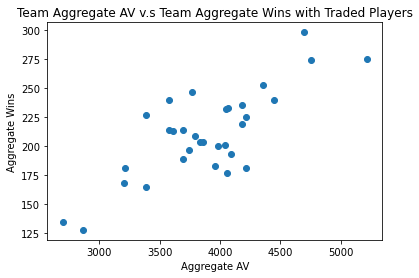

In [31]:
plt.scatter(total_historical_av.av, total_historical_av.W)
plt.xlabel('Aggregate AV')
plt.ylabel('Aggregate Wins')
plt.title('Team Aggregate AV v.s Team Aggregate Wins with Traded Players')

As we can tell here, overall draft AV is strongly correlated to wins and playoff performance. 

Now let's compare these teams to their next five years records rather than overall.

First, we will form a dataframe with the draft year and then a column for each of the next five years win count and playoff status. Then we will make a calculated column of the total wins and playoff performance.

In [32]:
tpf = tpf.sort_values(by='year')

In [33]:
w_year_1 = []
w_year_2 = []
w_year_3 = []
w_year_4 = []
w_year_5 = []

playoff_year_1 = []
playoff_year_2 = []
playoff_year_3 = []
playoff_year_4 = []
playoff_year_5 = []


for row in dav.values:
    team = row[1]
    year = row[0]
    
    #Form draft_year+ win count
    try:
        w_year_1.append(tpf['W'][(tpf.year == (year+1)) & (tpf.team == team)].values[0])
        w_year_2.append(tpf['W'][(tpf.year == (year+2)) & (tpf.team == team)].values[0])
        w_year_3.append(tpf['W'][(tpf.year == (year+3)) & (tpf.team == team)].values[0])
        w_year_4.append(tpf['W'][(tpf.year == (year+4)) & (tpf.team == team)].values[0])
        w_year_5.append(tpf['W'][(tpf.year == (year+5)) & (tpf.team == team)].values[0])
        
    except:
        pass
    
    #Form draft_year+ playoff performance
    try:
        playoff_year_1.append(tpf['Playoffs'][(tpf.year == (year+1)) & (tpf.team == team)].values[0])
        playoff_year_2.append(tpf['Playoffs'][(tpf.year == (year+2)) & (tpf.team == team)].values[0])
        playoff_year_3.append(tpf['Playoffs'][(tpf.year == (year+3)) & (tpf.team == team)].values[0])
        playoff_year_4.append(tpf['Playoffs'][(tpf.year == (year+4)) & (tpf.team == team)].values[0])
        playoff_year_5.append(tpf['Playoffs'][(tpf.year == (year+5)) & (tpf.team == team)].values[0])
        
    except:
        pass

In [34]:
#Place lists into dav dataframe
dav['w_year_1'] = pd.Series(w_year_1)
dav['w_year_2'] = pd.Series(w_year_2)
dav['w_year_3'] = pd.Series(w_year_3)
dav['w_year_4'] = pd.Series(w_year_4)
dav['w_year_5'] = pd.Series(w_year_5)

dav['playoff_year_1'] = pd.Series(playoff_year_1)
dav['playoff_year_2'] = pd.Series(playoff_year_2)
dav['playoff_year_3'] = pd.Series(playoff_year_3)
dav['playoff_year_4'] = pd.Series(playoff_year_4)
dav['playoff_year_5'] = pd.Series(playoff_year_5)

In [35]:
dav['w_total'] = dav['w_year_1'] +dav['w_year_2'] +dav['w_year_3'] +dav['w_year_4'] +dav['w_year_5']
dav['playoff_total'] = dav['playoff_year_1'] + dav['playoff_year_2'] + dav['playoff_year_3'] + dav['playoff_year_4'] + dav['playoff_year_5']
dav

,draft_year,team draft,av,w_year_1,w_year_2,w_year_3,w_year_4,w_year_5,playoff_year_1,playoff_year_2,playoff_year_3,playoff_year_4,playoff_year_5,w_total,playoff_total
0,1994,Arizona Cardinals,168.0,4.0,7.0,4.0,9.0,6.0,0.0,0.0,0.0,2.0,0.0,30.0,2.0
1,1994,Atlanta Falcons,96.0,9.0,3.0,7.0,14.0,5.0,1.0,0.0,0.0,4.0,0.0,38.0,5.0
2,1994,Buffalo Bills,136.0,10.0,10.0,6.0,10.0,11.0,2.0,1.0,0.0,1.0,1.0,47.0,5.0
3,1994,Chicago Bears,173.0,9.0,7.0,4.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0
4,1994,Cincinnati Bengals,226.0,7.0,8.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,2021,San Francisco 49ers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877,2021,Seattle Seahawks,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878,2021,Tampa Bay Buccaneers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879,2021,Tennessee Titans,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
dav.corr()

,draft_year,av,w_year_1,w_year_2,w_year_3,w_year_4,w_year_5,playoff_year_1,playoff_year_2,playoff_year_3,playoff_year_4,playoff_year_5,w_total,playoff_total
draft_year,1.000000,-0.486553,-0.013139,-0.007558,-0.007333,-0.011193,-0.003451,-0.017131,-0.003821,-0.010309,-0.006014,0.009636,-0.016877,-0.015928
av,-0.486553,1.000000,-0.005318,-0.027337,0.008510,-0.033432,-0.030680,-0.016742,0.010317,-0.020280,-0.062043,-0.046978,-0.041411,-0.053901
w_year_1,-0.013139,-0.005318,1.000000,-0.005884,-0.041403,-0.035129,-0.048244,0.725121,0.034796,-0.000155,-0.011760,-0.005743,0.352300,0.298394
w_year_2,-0.007558,-0.027337,-0.005884,1.000000,-0.032848,-0.014044,-0.045299,-0.033054,0.723837,-0.026637,0.043801,-0.019566,0.363272,0.283873
w_year_3,-0.007333,0.008510,-0.041403,-0.032848,1.000000,0.304656,0.248993,-0.069411,-0.007877,0.724329,0.276200,0.205915,0.590340,0.448209
w_year_4,-0.011193,-0.033432,-0.035129,-0.014044,0.304656,1.000000,0.297005,-0.065614,0.048069,0.280099,0.721288,0.276397,0.616427,0.497873
w_year_5,-0.003451,-0.030680,-0.048244,-0.045299,0.248993,0.297005,1.000000,-0.062820,0.000561,0.201806,0.272284,0.714099,0.581157,0.445468
playoff_year_1,-0.017131,-0.016742,0.725121,-0.033054,-0.069411,-0.065614,-0.062820,1.000000,0.002431,-0.020158,-0.028745,-0.037942,0.207266,0.369164
playoff_year_2,-0.003821,0.010317,0.034796,0.723837,-0.007877,0.048069,0.000561,0.002431,1.000000,-0.009979,0.075415,-0.010219,0.315053,0.423439
playoff_year_3,-0.010309,-0.020280,-0.000155,-0.026637,0.724329,0.280099,0.201806,-0.020158,-0.009979,1.000000,0.245898,0.187762,0.477036,0.564725


Looking at correlations, we begin to see that there is little correlation between a team's total AV for a draft year and their performance (wins and playoffs) over the next five years. This however, is likely because a lot of people get traded, so therefore even though the AV gets attributed to the draft team, the value was actually performed by another team. 

A great example of this is the 2004 Chargers. They have the highest total AV of any draft team, but much of their AV comes from Eli Manning, who was instantly traded the New York Giants and played a successful 16 year career there, ultimately accumulating 169 AV for the Giants. 

Therefore, we need to look past players that were traded, and only account for AV provided to their draft team.

#### Draft Analysis - Only players who stuck with the team

In [37]:
df = dapdf[dapdf['team draft'] == dapdf['team year']]

In [38]:
dfgrouped = df.groupby(by=['draft_year','team draft'], as_index = False)['av'].sum()
dfgrouped.sort_values(by=['av'], ascending=False).head(10)

,draft_year,team draft,av
60,1996,Baltimore Ravens,383.0
391,2006,New Orleans Saints,374.0
434,2008,Atlanta Falcons,360.0
589,2012,Seattle Seahawks,353.0
305,2004,Arizona Cardinals,334.0
55,1995,Tampa Bay Buccaneers,330.0
199,2000,New England Patriots,327.0
428,2007,San Francisco 49ers,310.0
142,1998,Pittsburgh Steelers,301.0
222,2001,Indianapolis Colts,301.0


As you can see, the top ten draft teams are different now then when all players, regardless of trade status, were included. 

Let's see now how this correlates to team performance

In [39]:
total_team_av2 = dfgrouped.groupby(by=['team draft'], as_index = False)['av'].sum()
total_team_av2 = total_team_av2.rename(columns={'team draft':'team'})
total_historical_av2 = total_team_av2.join(historical_by_team.set_index('team'), on = 'team')
total_historical_av2.sort_values(by='av', ascending = False)

,team,av,W,Playoffs
26,Pittsburgh Steelers,3586.0,274,45.0
11,Green Bay Packers,3550.0,275,49.0
21,New England Patriots,3366.0,298,68.0
13,Indianapolis Colts,3180.0,253,37.0
2,Baltimore Ravens,3114.0,225,32.0
6,Cincinnati Bengals,2984.0,181,7.0
25,Philadelphia Eagles,2885.0,235,34.0
8,Dallas Cowboys,2869.0,232,24.0
28,Seattle Seahawks,2834.0,240,32.0
30,Tennessee Titans,2823.0,201,20.0


In [40]:
total_historical_av2.corr()

,av,W,Playoffs
av,1.000000,0.799968,0.782515
W,0.799968,1.000000,0.901731
Playoffs,0.782515,0.901731,1.000000


Text(0.5, 1.0, 'Team Aggregate AV v.s Team Aggregate Wins without Traded Players')

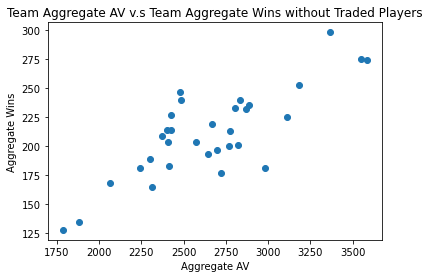

In [41]:
plt.scatter(total_historical_av2.av, total_historical_av2.W)
plt.xlabel('Aggregate AV')
plt.ylabel('Aggregate Wins')
plt.title('Team Aggregate AV v.s Team Aggregate Wins without Traded Players')

Once players who were traded are removed, there is still a strong correlation of total performance and AV, but it is slightly stronger than before.

In [42]:
w_year_1 = []
w_year_2 = []
w_year_3 = []
w_year_4 = []
w_year_5 = []

playoff_year_1 = []
playoff_year_2 = []
playoff_year_3 = []
playoff_year_4 = []
playoff_year_5 = []


for row in dfgrouped.values:
    team = row[1]
    year = row[0]
    
    #Form draft_year+ win count
    try:
        w_year_1.append(tpf['W'][(tpf.year == (year+1)) & (tpf.team == team)].values[0])
        w_year_2.append(tpf['W'][(tpf.year == (year+2)) & (tpf.team == team)].values[0])
        w_year_3.append(tpf['W'][(tpf.year == (year+3)) & (tpf.team == team)].values[0])
        w_year_4.append(tpf['W'][(tpf.year == (year+4)) & (tpf.team == team)].values[0])
        w_year_5.append(tpf['W'][(tpf.year == (year+5)) & (tpf.team == team)].values[0])
        
    except:
        pass
    
    #Form draft_year+ playoff performance
    try:
        playoff_year_1.append(tpf['Playoffs'][(tpf.year == (year+1)) & (tpf.team == team)].values[0])
        playoff_year_2.append(tpf['Playoffs'][(tpf.year == (year+2)) & (tpf.team == team)].values[0])
        playoff_year_3.append(tpf['Playoffs'][(tpf.year == (year+3)) & (tpf.team == team)].values[0])
        playoff_year_4.append(tpf['Playoffs'][(tpf.year == (year+4)) & (tpf.team == team)].values[0])
        playoff_year_5.append(tpf['Playoffs'][(tpf.year == (year+5)) & (tpf.team == team)].values[0])
        
    except:
        pass
    

#Place lists into dav dataframe
dfgrouped['w_year_1'] = pd.Series(w_year_1)
dfgrouped['w_year_2'] = pd.Series(w_year_2)
dfgrouped['w_year_3'] = pd.Series(w_year_3)
dfgrouped['w_year_4'] = pd.Series(w_year_4)
dfgrouped['w_year_5'] = pd.Series(w_year_5)

dfgrouped['playoff_year_1'] = pd.Series(playoff_year_1)
dfgrouped['playoff_year_2'] = pd.Series(playoff_year_2)
dfgrouped['playoff_year_3'] = pd.Series(playoff_year_3)
dfgrouped['playoff_year_4'] = pd.Series(playoff_year_4)
dfgrouped['playoff_year_5'] = pd.Series(playoff_year_5)

#Show the dataframe
dfgrouped['w_total'] = dfgrouped['w_year_1'] +dfgrouped['w_year_2'] +dfgrouped['w_year_3'] +dfgrouped['w_year_4'] +dfgrouped['w_year_5']
dfgrouped['playoff_total'] = dfgrouped['playoff_year_1'] + dfgrouped['playoff_year_2'] + dfgrouped['playoff_year_3'] + dfgrouped['playoff_year_4'] + dfgrouped['playoff_year_5']
dfgrouped

,draft_year,team draft,av,w_year_1,w_year_2,w_year_3,w_year_4,w_year_5,playoff_year_1,playoff_year_2,playoff_year_3,playoff_year_4,playoff_year_5,w_total,playoff_total
0,1994,Arizona Cardinals,56.0,4.0,7.0,4.0,9.0,6.0,0.0,0.0,0.0,2.0,0.0,30.0,2.0
1,1994,Atlanta Falcons,86.0,9.0,3.0,7.0,14.0,5.0,1.0,0.0,0.0,4.0,0.0,38.0,5.0
2,1994,Buffalo Bills,93.0,10.0,10.0,6.0,10.0,11.0,2.0,1.0,0.0,1.0,1.0,47.0,5.0
3,1994,Chicago Bears,83.0,9.0,7.0,4.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0
4,1994,Cincinnati Bengals,112.0,7.0,8.0,7.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,29.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,2021,San Francisco 49ers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877,2021,Seattle Seahawks,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878,2021,Tampa Bay Buccaneers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879,2021,Tennessee Titans,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
dfgrouped.corr()

,draft_year,av,w_year_1,w_year_2,w_year_3,w_year_4,w_year_5,playoff_year_1,playoff_year_2,playoff_year_3,playoff_year_4,playoff_year_5,w_total,playoff_total
draft_year,1.000000,-0.356524,-0.013139,-0.007558,-0.007333,-0.011193,-0.003451,-0.017131,-0.003821,-0.010309,-0.006014,0.009636,-0.016877,-0.015928
av,-0.356524,1.000000,-0.029258,-0.028524,-0.003097,-0.035261,-0.067276,-0.029704,-0.018789,-0.033574,-0.031305,-0.085768,-0.075643,-0.083468
w_year_1,-0.013139,-0.029258,1.000000,-0.005884,-0.041403,-0.035129,-0.048244,0.725121,0.034796,-0.000155,-0.011760,-0.005743,0.352300,0.298394
w_year_2,-0.007558,-0.028524,-0.005884,1.000000,-0.032848,-0.014044,-0.045299,-0.033054,0.723837,-0.026637,0.043801,-0.019566,0.363272,0.283873
w_year_3,-0.007333,-0.003097,-0.041403,-0.032848,1.000000,0.304656,0.248993,-0.069411,-0.007877,0.724329,0.276200,0.205915,0.590340,0.448209
w_year_4,-0.011193,-0.035261,-0.035129,-0.014044,0.304656,1.000000,0.297005,-0.065614,0.048069,0.280099,0.721288,0.276397,0.616427,0.497873
w_year_5,-0.003451,-0.067276,-0.048244,-0.045299,0.248993,0.297005,1.000000,-0.062820,0.000561,0.201806,0.272284,0.714099,0.581157,0.445468
playoff_year_1,-0.017131,-0.029704,0.725121,-0.033054,-0.069411,-0.065614,-0.062820,1.000000,0.002431,-0.020158,-0.028745,-0.037942,0.207266,0.369164
playoff_year_2,-0.003821,-0.018789,0.034796,0.723837,-0.007877,0.048069,0.000561,0.002431,1.000000,-0.009979,0.075415,-0.010219,0.315053,0.423439
playoff_year_3,-0.010309,-0.033574,-0.000155,-0.026637,0.724329,0.280099,0.201806,-0.020158,-0.009979,1.000000,0.245898,0.187762,0.477036,0.564725


Again, we encounter the same correlations as before. This tells me that draft performance is measured by far more than one year of a draft. Since there is a strong correlation between aggregate draft success and aggregate team success, the key is not having one successful draft year. It is about consistently drafting players who perform well in the NFL, not just for your team.

Essentially, this means that from one draft year, you cannot properly predict team performance over the next 5 years.

However, since there is a correlation on the aggregate, this raises the question: how many draft years does it take to begin predicting team performance? 

Let's dive in!

## Team Performance Predictions based on Draft Performance

In [44]:
total_historical_av2

,team,av,W,Playoffs
0,Arizona Cardinals,2415.0,183,12.0
1,Atlanta Falcons,2775.0,213,23.0
2,Baltimore Ravens,3114.0,225,32.0
3,Buffalo Bills,2409.0,204,10.0
4,Carolina Panthers,2769.0,200,21.0
5,Chicago Bears,2571.0,204,15.0
6,Cincinnati Bengals,2984.0,181,7.0
7,Cleveland Browns,1786.0,128,5.0
8,Dallas Cowboys,2869.0,232,24.0
9,Denver Broncos,2481.0,247,33.0
